# Data Ingestion Pipelines for Toronto Weather Data via APIs

Authors - DONGCHEN WU, RUNZE XU,SUSHMIT RICHARD 

A common problem in Logistics is the optimization of delivery routes using distance and weather data. Identify an API that can provide:

1. Current Weather
2. Weather Forecasts
3. Weather Alerts (you will need to work with the data available here: https://dd.weather.gc.ca/Links to an external site.)


- Create an uploads schema in your own database within our Postgres server (do not use the mban_db database)
- Prepare a data ingestion pipeline for each data source. The data ingestion pipeline must be designed to be scheduled (i.e. it should take the current date as an input so it can run every day and update your tables)
- Each data ingestion pipeline must include data cleaning and feature engineering
- Create new tables in the uploads schema to capture the weather data.

In [1]:
import sqlalchemy as sa
from datetime import timedelta,datetime
import pandas as pd
import numpy as np
import requests
import json
import time
import os
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
from shapely.geometry import Point, Polygon
import overpy
import re
from translate import Translator

In [2]:
#Database Credentials
my_db_secret = {
    'drivername': 'postgresql+psycopg2', 
    'host': 'mmai5100postgres.canadacentral.cloudapp.azure.com',
    'port': '5432', 
    'username': 'sushmit9', 
    'password': '2023!Schulich',
    'database': 'sushmit9_db'
}

#Creating Databse URL
my_db_url = sa.engine.URL.create(
    drivername = my_db_secret['drivername'],
    username = my_db_secret['username'],
    password = my_db_secret['password'],
    host = my_db_secret['host'],
    port = my_db_secret['port'],
    database = my_db_secret['database'])

# Create the SQLAlchemy engine
my_db_engine = sa.create_engine(my_db_url)

# 1. Current Weather for Toronto

#### Fetching Data

In [5]:
# Data Source: https://openweathermap.org/current
lat= 43.6532
lon = -79.3832
api_key = "7bada83efe23d6a1b6204c7ee293a2f4"
api_url = 'https://api.openweathermap.org/data/2.5/weather?lat={}&lon={}&appid={}'.format(lat, lon, api_key)
data = requests.get(api_url)
data = data.json()
data    

{'coord': {'lon': -79.3839, 'lat': 43.6535},
 'weather': [{'id': 804,
   'main': 'Clouds',
   'description': 'overcast clouds',
   'icon': '04d'}],
 'base': 'stations',
 'main': {'temp': 296.44,
  'feels_like': 296.5,
  'temp_min': 294.3,
  'temp_max': 298.27,
  'pressure': 1012,
  'humidity': 64},
 'visibility': 10000,
 'wind': {'speed': 2.24, 'deg': 105, 'gust': 5.36},
 'clouds': {'all': 100},
 'dt': 1692051058,
 'sys': {'type': 2,
  'id': 2040045,
  'country': 'CA',
  'sunrise': 1692008447,
  'sunset': 1692059036},
 'timezone': -14400,
 'id': 6167863,
 'name': 'Downtown Toronto',
 'cod': 200}

#### Feature Engineering

In [5]:
# Flatten the nested dictionaries
flattened_data = {
    'lon': data['coord']['lon'],
    'lat': data['coord']['lat'],
    'weather_id': data['weather'][0]['id'],
    'weather_main': data['weather'][0]['main'],
    'weather_description': data['weather'][0]['description'],
    'weather_icon': data['weather'][0]['icon'],
    'base': data['base'],
    'temp': data['main']['temp'],
    'feels_like': data['main']['feels_like'],
    'temp_min': data['main']['temp_min'],
    'temp_max': data['main']['temp_max'],
    'pressure': data['main']['pressure'],
    'humidity': data['main']['humidity'],
    'visibility': data['visibility'],
    'wind_speed': data['wind']['speed'],
    'wind_deg': data['wind']['deg'],
    'clouds_all': data['clouds']['all'],
    'dt': data['dt'],
    'sys_type': data['sys']['type'],
    'sys_id': data['sys']['id'],
    'sys_country': data['sys']['country'],
    'sys_sunrise': data['sys']['sunrise'],
    'sys_sunset': data['sys']['sunset'],
    'timezone': data['timezone'],
    'city_id': data['id'],
    'city_name': data['name'],
    'cod': data['cod']
    }

# Convert the flattened data to a DataFrame
df = pd.DataFrame(flattened_data, index=[0])
df

,lon,lat,weather_id,weather_main,weather_description,weather_icon,base,temp,feels_like,temp_min,...,dt,sys_type,sys_id,sys_country,sys_sunrise,sys_sunset,timezone,city_id,city_name,cod
0,-79.3832,43.6532,804,Clouds,overcast clouds,04d,stations,297.9,298,296.46,...,1691962228,1,718,CA,1691921979,1691972724,-14400,6167863,Downtown Toronto,200


In [6]:
# Convert UNIX timestamps to 'hh:mm:ss' format using lambda function
df['dt'] = df['dt'].apply(lambda unix_time: datetime.utcfromtimestamp(unix_time).strftime('%H:%M:%S'))
df['sys_sunrise'] = df['sys_sunrise'].apply(lambda unix_time: datetime.utcfromtimestamp(unix_time).strftime('%H:%M:%S'))
df['sys_sunset'] = df['sys_sunset'].apply(lambda unix_time: datetime.utcfromtimestamp(unix_time).strftime('%H:%M:%S'))
# Convert timezone shift to 'hhmm' format using lambda function
df['timezone'] = df['timezone'].apply(lambda shift: ('-' if shift < 0 else '') + '{:02d}{:02d}'.format(abs(shift) // 3600, (abs(shift) % 3600) // 60))

df

,lon,lat,weather_id,weather_main,weather_description,weather_icon,base,temp,feels_like,temp_min,...,dt,sys_type,sys_id,sys_country,sys_sunrise,sys_sunset,timezone,city_id,city_name,cod
0,-79.3832,43.6532,804,Clouds,overcast clouds,04d,stations,297.9,298,296.46,...,21:30:28,1,718,CA,10:19:39,00:25:24,-0400,6167863,Downtown Toronto,200


In [7]:
df.columns

Index(['lon', 'lat', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon', 'base', 'temp', 'feels_like', 'temp_min', 'temp_max',
       'pressure', 'humidity', 'visibility', 'wind_speed', 'wind_deg',
       'clouds_all', 'dt', 'sys_type', 'sys_id', 'sys_country', 'sys_sunrise',
       'sys_sunset', 'timezone', 'city_id', 'city_name', 'cod'],
      dtype='object')

In [8]:
#Dropping unneceassry columns and intenal parameters
df.drop(['weather_id','weather_icon','base','sys_type','sys_id', 'cod'], axis=1, inplace=True)
df

,lon,lat,weather_main,weather_description,temp,feels_like,temp_min,temp_max,pressure,humidity,...,wind_speed,wind_deg,clouds_all,dt,sys_country,sys_sunrise,sys_sunset,timezone,city_id,city_name
0,-79.3832,43.6532,Clouds,overcast clouds,297.9,298,296.46,299.4,1014,60,...,6.17,270,100,21:30:28,CA,10:19:39,00:25:24,-0400,6167863,Downtown Toronto


In [9]:
df.dtypes

lon                    float64
lat                    float64
weather_main            object
weather_description     object
temp                   float64
feels_like               int64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
visibility               int64
wind_speed             float64
wind_deg                 int64
clouds_all               int64
dt                      object
sys_country             object
sys_sunrise             object
sys_sunset              object
timezone                object
city_id                  int64
city_name               object
dtype: object

#### DATA INGESTION PIPELINE

In [10]:
# Function to fetch and ingest data - compiling everything above into a function
def fetch_and_ingest_data():
    lat= 43.6532
    lon = -79.3832
    api_key = "7bada83efe23d6a1b6204c7ee293a2f4"
    api_url = 'https://api.openweathermap.org/data/2.5/weather?lat={}&lon={}&appid={}'.format(lat, lon, api_key)
    data = requests.get(api_url)
    data = data.json()
    
    # Flatten the nested dictionaries
    flattened_data = {
    'lon': data['coord']['lon'],
    'lat': data['coord']['lat'],
    'weather_id': data['weather'][0]['id'],
    'weather_main': data['weather'][0]['main'],
    'weather_description': data['weather'][0]['description'],
    'weather_icon': data['weather'][0]['icon'],
    'base': data['base'],
    'temp': data['main']['temp'],
    'feels_like': data['main']['feels_like'],
    'temp_min': data['main']['temp_min'],
    'temp_max': data['main']['temp_max'],
    'pressure': data['main']['pressure'],
    'humidity': data['main']['humidity'],
    'visibility': data['visibility'],
    'wind_speed': data['wind']['speed'],
    'wind_deg': data['wind']['deg'],
    'clouds_all': data['clouds']['all'],
    'dt': data['dt'],
    'sys_type': data['sys']['type'],
    'sys_id': data['sys']['id'],
    'sys_country': data['sys']['country'],
    'sys_sunrise': data['sys']['sunrise'],
    'sys_sunset': data['sys']['sunset'],
    'timezone': data['timezone'],
    'city_id': data['id'],
    'city_name': data['name'],
    'cod': data['cod']
    }
    
    # Convert the flattened data to a DataFrame
    df = pd.DataFrame(flattened_data, index=[0])

    # Convert UNIX timestamps to 'hh:mm:ss' format using lambda function
    df['dt'] = df['dt'].apply(lambda unix_time: datetime.utcfromtimestamp(unix_time).strftime('%H:%M:%S'))
    df['sys_sunrise'] = df['sys_sunrise'].apply(lambda unix_time: datetime.utcfromtimestamp(unix_time).strftime('%H:%M:%S'))
    df['sys_sunset'] = df['sys_sunset'].apply(lambda unix_time: datetime.utcfromtimestamp(unix_time).strftime('%H:%M:%S'))
    
    # Convert timezone shift to 'hhmm' format using lambda function
    df['timezone'] = df['timezone'].apply(lambda shift: ('-' if shift < 0 else '') + '{:02d}{:02d}'.format(abs(shift) // 3600, (abs(shift) % 3600) // 60))

    
    #Dropping unneceassry columns and intenal parameters
    df.drop(['weather_id','weather_icon','base','sys_type','sys_id', 'cod'], axis=1, inplace=True)

    #Pushing dataframe to Database Schema
    df.to_sql(
    name      = 'Toronto_current_weather',
    con       = my_db_engine,
    schema    = 'Uploads',
    if_exists = 'append', # add new rows to the existing table
    index     = False,
    method    = 'multi',
    dtype     = {
        'lon'                 : sa.types.FLOAT,
        'lat'                 : sa.types.FLOAT,
        'weather_main'        : sa.types.VARCHAR(30),
        'weather_description' : sa.types.VARCHAR(30),
        'temp'                : sa.types.FLOAT,
        'feels_like'          : sa.types.FLOAT,
        'temp_min'            : sa.types.FLOAT,
        'temp_max'            : sa.types.FLOAT,
        'pressure'            : sa.types.INTEGER,
        'humidity'            : sa.types.INTEGER,
        'visibility'          : sa.types.INTEGER,
        'wind_speed'          : sa.types.FLOAT,
        'wind_deg'            : sa.types.INTEGER,
        'clouds_all'          : sa.types.INTEGER,
        'dt'                  : sa.types.VARCHAR(30),
        'sys_country'         : sa.types.VARCHAR(30),
        'sys_sunrise'         : sa.types.VARCHAR(30),
        'sys_sunset'          : sa.types.VARCHAR(30),
        'timezone'            : sa.types.VARCHAR(30),
        'city_id'             : sa.types.INTEGER,
        'city_name'           : sa.types.VARCHAR(30)
    }
    )

# Immediately run the data fetching and ingestion process
print("Running data fetching and ingestion process immediately...")
fetch_and_ingest_data()
print("Data fetching and ingestion process has been executed.")

Running data fetching and ingestion process immediately...
Data fetching and ingestion process has been executed.


Evidence
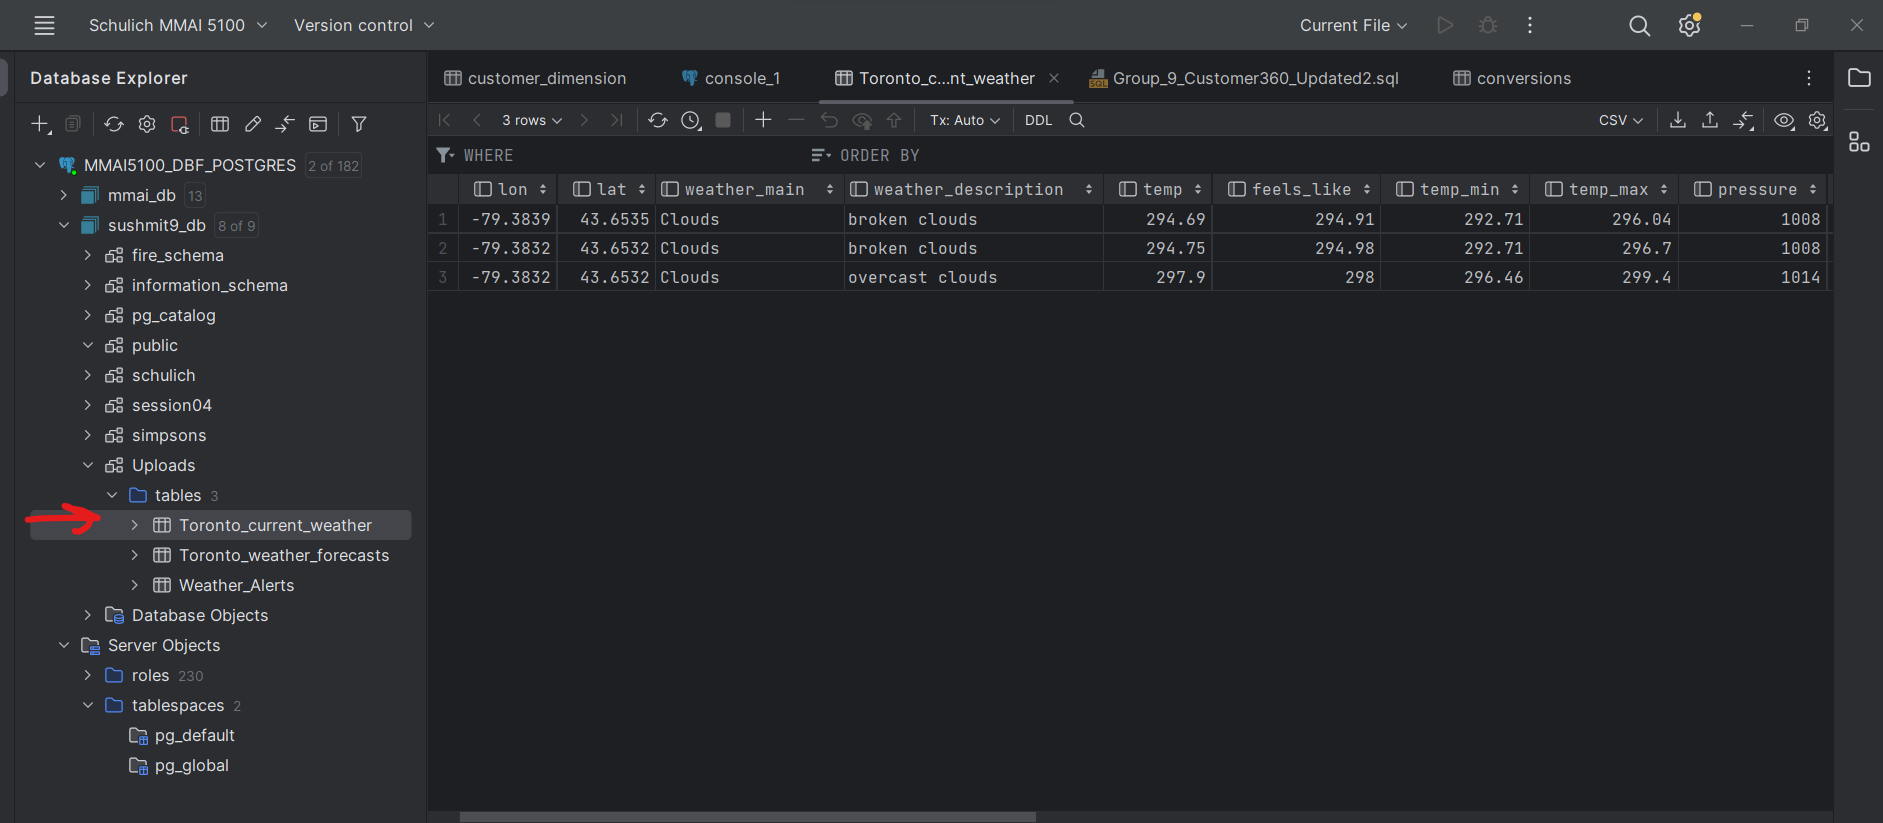

In [12]:
# Schedule the data fetching and ingestion process to run daily from the next day onwards
# P.S. - This is meant to be executed in the background. 
def schedule_daily_task(hour, minute):
    while True:
        current_time = time.localtime()
        if current_time.tm_hour >= hour and current_time.tm_min >= minute:
            break
        time.sleep(60)  # Sleep for a minute

    while True:
        fetch_and_ingest_data()
        print("Data fetching and ingestion process has been scheduled and executed.")
        time.sleep(24 * 60 * 60)  # Sleep for a day

# Schedule the data fetching and ingestion process to run every day at 12:00 PM
schedule_daily_task(hour=12, minute=0)

# 2. Weather Forecasts for Toronto

#### Fetching Data

In [11]:
# Data Source: https://openweathermap.org/api/hourly-forecast
lat2= 43.6532
lon2 = -79.3832
api_key2 = "583b9776c32850d28350562414730cb1"
api_url2 = 'https://pro.openweathermap.org/data/2.5/forecast/hourly?lat={}&lon={}&appid={}'.format(lat2, lon2, api_key2)
data2 = requests.get(api_url2)
data2 = data2.json()
data2   

{'cod': '200',
 'message': 0,
 'cnt': 96,
 'list': [{'dt': 1691964000,
   'main': {'temp': 297.51,
    'feels_like': 297.62,
    'temp_min': 295.32,
    'temp_max': 297.51,
    'pressure': 1013,
    'sea_level': 1013,
    'grnd_level': 1004,
    'humidity': 62,
    'temp_kf': 2.19},
   'weather': [{'id': 804,
     'main': 'Clouds',
     'description': 'overcast clouds',
     'icon': '04d'}],
   'clouds': {'all': 100},
   'wind': {'speed': 5.7, 'deg': 329, 'gust': 7.92},
   'visibility': 10000,
   'pop': 0,
   'sys': {'pod': 'd'},
   'dt_txt': '2023-08-13 22:00:00'},
  {'dt': 1691967600,
   'main': {'temp': 296.97,
    'feels_like': 297.05,
    'temp_min': 294.79,
    'temp_max': 296.97,
    'pressure': 1013,
    'sea_level': 1013,
    'grnd_level': 1004,
    'humidity': 63,
    'temp_kf': 2.18},
   'weather': [{'id': 804,
     'main': 'Clouds',
     'description': 'overcast clouds',
     'icon': '04d'}],
   'clouds': {'all': 98},
   'wind': {'speed': 5.56, 'deg': 331, 'gust': 7.69},
  

#### Feature Engineering

In [12]:
# Flatten the nested data
flat_data_list = []

for item in data2['list']:
    flat_data = {
        'dt': item['dt'],
        'temp': item['main']['temp'],
        'feels_like': item['main']['feels_like'],
        'temp_min': item['main']['temp_min'],
        'temp_max': item['main']['temp_max'],
        'pressure': item['main']['pressure'],
        'sea_level': item['main'].get('sea_level'),  # Check if key exists
        'grnd_level': item['main'].get('grnd_level'),  # Check if key exists
        'temp_kf': item['main'].get('temp_kf'),  # Check if key exists
        'humidity': item['main']['humidity'],
        'weather_id': item['weather'][0]['id'],
        'weather_main': item['weather'][0]['main'],
        'weather_description': item['weather'][0]['description'],
        'weather_icon': item['weather'][0]['icon'],
        'clouds_all': item['clouds']['all'],
        'wind_speed': item['wind']['speed'],
        'wind_deg': item['wind']['deg'],
        'gust': item['wind']['gust'],
        'visibility': item['visibility'],
        'pop': item['pop'],
        'sys_pod': item['sys']['pod'],
        'dt_txt': item['dt_txt'],
        'city_id': data2['city']['id'],
        'city_name': data2['city']['name'],
        'city_lat': data2['city']['coord']['lat'],
        'city_lon': data2['city']['coord']['lon'],
        'city_country': data2['city']['country'],
        'city_timezone': data2['city']['timezone'],
        'city_sunrise': data2['city']['sunrise'],
        'city_sunset': data2['city']['sunset']
    }
    flat_data_list.append(flat_data)

# Convert the flattened data to a DataFrame
df2 = pd.DataFrame(flat_data_list)

df2.head()

,dt,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,temp_kf,humidity,...,sys_pod,dt_txt,city_id,city_name,city_lat,city_lon,city_country,city_timezone,city_sunrise,city_sunset
0,1691964000,297.51,297.62,295.32,297.51,1013,1013,1004,2.19,62,...,d,2023-08-13 22:00:00,6167863,Downtown Toronto,43.6532,-79.3832,CA,-14400,1691921979,1691972724
1,1691967600,296.97,297.05,294.79,296.97,1013,1013,1004,2.18,63,...,d,2023-08-13 23:00:00,6167863,Downtown Toronto,43.6532,-79.3832,CA,-14400,1691921979,1691972724
2,1691971200,296.11,296.11,294.00,296.11,1014,1014,1005,2.11,63,...,d,2023-08-14 00:00:00,6167863,Downtown Toronto,43.6532,-79.3832,CA,-14400,1691921979,1691972724
3,1691974800,294.83,294.75,293.04,294.83,1015,1015,1006,1.79,65,...,n,2023-08-14 01:00:00,6167863,Downtown Toronto,43.6532,-79.3832,CA,-14400,1691921979,1691972724
4,1691978400,293.41,293.24,292.39,293.41,1015,1015,1006,1.02,67,...,n,2023-08-14 02:00:00,6167863,Downtown Toronto,43.6532,-79.3832,CA,-14400,1691921979,1691972724


In [13]:
df2.columns

Index(['dt', 'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure',
       'sea_level', 'grnd_level', 'temp_kf', 'humidity', 'weather_id',
       'weather_main', 'weather_description', 'weather_icon', 'clouds_all',
       'wind_speed', 'wind_deg', 'gust', 'visibility', 'pop', 'sys_pod',
       'dt_txt', 'city_id', 'city_name', 'city_lat', 'city_lon',
       'city_country', 'city_timezone', 'city_sunrise', 'city_sunset'],
      dtype='object')

In [14]:
# Convert UNIX timestamps to 'hh:mm:ss' format using lambda function
df2['dt'] = df2['dt'].apply(lambda unix_time: datetime.utcfromtimestamp(unix_time).strftime('%H:%M:%S'))
df2['city_sunrise'] = df2['city_sunrise'].apply(lambda unix_time: datetime.utcfromtimestamp(unix_time).strftime('%H:%M:%S'))
df2['city_sunset'] = df2['city_sunset'].apply(lambda unix_time: datetime.utcfromtimestamp(unix_time).strftime('%H:%M:%S'))
# Convert timezone shift to 'hhmm' format using lambda function
df2['city_timezone'] = df2['city_timezone'].apply(lambda shift: ('-' if shift < 0 else '') + '{:02d}{:02d}'.format(abs(shift) // 3600, (abs(shift) % 3600) // 60))

df2.head(3)

,dt,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,temp_kf,humidity,...,sys_pod,dt_txt,city_id,city_name,city_lat,city_lon,city_country,city_timezone,city_sunrise,city_sunset
0,22:00:00,297.51,297.62,295.32,297.51,1013,1013,1004,2.19,62,...,d,2023-08-13 22:00:00,6167863,Downtown Toronto,43.6532,-79.3832,CA,-0400,10:19:39,00:25:24
1,23:00:00,296.97,297.05,294.79,296.97,1013,1013,1004,2.18,63,...,d,2023-08-13 23:00:00,6167863,Downtown Toronto,43.6532,-79.3832,CA,-0400,10:19:39,00:25:24
2,00:00:00,296.11,296.11,294.00,296.11,1014,1014,1005,2.11,63,...,d,2023-08-14 00:00:00,6167863,Downtown Toronto,43.6532,-79.3832,CA,-0400,10:19:39,00:25:24


In [15]:
#Dropping unneceassry columns and intenal parameters
df2.drop(['temp_kf','weather_id','weather_icon','city_id'], axis=1, inplace=True)
df2.head(1)

,dt,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,weather_main,...,pop,sys_pod,dt_txt,city_name,city_lat,city_lon,city_country,city_timezone,city_sunrise,city_sunset
0,22:00:00,297.51,297.62,295.32,297.51,1013,1013,1004,62,Clouds,...,0.0,d,2023-08-13 22:00:00,Downtown Toronto,43.6532,-79.3832,CA,-0400,10:19:39,00:25:24


In [16]:
df2.dtypes

dt                      object
temp                   float64
feels_like             float64
temp_min               float64
temp_max               float64
pressure                 int64
sea_level                int64
grnd_level               int64
humidity                 int64
weather_main            object
weather_description     object
clouds_all               int64
wind_speed             float64
wind_deg                 int64
gust                   float64
visibility               int64
pop                    float64
sys_pod                 object
dt_txt                  object
city_name               object
city_lat               float64
city_lon               float64
city_country            object
city_timezone           object
city_sunrise            object
city_sunset             object
dtype: object

#### Data Ingestion Pipeline

In [17]:
# Function to fetch and ingest data - compiling everything above into a function
def fetch_and_ingest_data2():
    lat2= 43.6532
    lon2 = -79.3832
    api_key2 = "583b9776c32850d28350562414730cb1"
    api_url2 = 'https://pro.openweathermap.org/data/2.5/forecast/hourly?lat={}&lon={}&appid={}'.format(lat2, lon2, api_key2)
    data2 = requests.get(api_url2)
    data2 = data2.json()
   
    # Flatten the nested data
    flat_data_list = []
    
    for item in data2['list']:
        flat_data = {
        'dt': item['dt'],
        'temp': item['main']['temp'],
        'feels_like': item['main']['feels_like'],
        'temp_min': item['main']['temp_min'],
        'temp_max': item['main']['temp_max'],
        'pressure': item['main']['pressure'],
        'sea_level': item['main'].get('sea_level'),  # Check if key exists
        'grnd_level': item['main'].get('grnd_level'),  # Check if key exists
        'temp_kf': item['main'].get('temp_kf'),  # Check if key exists
        'humidity': item['main']['humidity'],
        'weather_id': item['weather'][0]['id'],
        'weather_main': item['weather'][0]['main'],
        'weather_description': item['weather'][0]['description'],
        'weather_icon': item['weather'][0]['icon'],
        'clouds_all': item['clouds']['all'],
        'wind_speed': item['wind']['speed'],
        'wind_deg': item['wind']['deg'],
        'gust': item['wind']['gust'],
        'visibility': item['visibility'],
        'pop': item['pop'],
        'sys_pod': item['sys']['pod'],
        'dt_txt': item['dt_txt'],
        'city_id': data2['city']['id'],
        'city_name': data2['city']['name'],
        'city_lat': data2['city']['coord']['lat'],
        'city_lon': data2['city']['coord']['lon'],
        'city_country': data2['city']['country'],
        'city_timezone': data2['city']['timezone'],
        'city_sunrise': data2['city']['sunrise'],
        'city_sunset': data2['city']['sunset']
        }
        flat_data_list.append(flat_data)
    
    # Convert the flattened data to a DataFrame
    df2 = pd.DataFrame(flat_data_list)

    # Convert UNIX timestamps to 'hh:mm:ss' format using lambda function
    df2['dt'] = df2['dt'].apply(lambda unix_time: datetime.utcfromtimestamp(unix_time).strftime('%H:%M:%S'))
    df2['city_sunrise'] = df2['city_sunrise'].apply(lambda unix_time: datetime.utcfromtimestamp(unix_time).strftime('%H:%M:%S'))
    df2['city_sunset'] = df2['city_sunset'].apply(lambda unix_time: datetime.utcfromtimestamp(unix_time).strftime('%H:%M:%S'))
    
    # Convert timezone shift to 'hhmm' format using lambda function
    df2['city_timezone'] = df2['city_timezone'].apply(lambda shift: ('-' if shift < 0 else '') + '{:02d}{:02d}'.format(abs(shift) // 3600, (abs(shift) % 3600) // 60))

    #Dropping unneceassry columns and intenal parameters
    df2.drop(['temp_kf','weather_id','weather_icon','city_id'], axis=1, inplace=True)

    #Pushing dataframe to Database Schema
    df2.to_sql(
    name      = 'Toronto_weather_forecasts',
    con       = my_db_engine,
    schema    = 'Uploads',
    if_exists = 'append', # add new rows to the existing table
    index     = False,
    method    = 'multi',
    dtype     = {
        'dt'                  : sa.types.VARCHAR(30),
        'temp'                : sa.types.FLOAT,
        'feels_like'          : sa.types.FLOAT,
        'temp_min'            : sa.types.FLOAT,
        'temp_max'            : sa.types.FLOAT,
        'pressure'            : sa.types.INTEGER,
        'sea_leve'            : sa.types.INTEGER,
        'grnd_level'          : sa.types.INTEGER,
        'humidity'            : sa.types.INTEGER,
        'weather_main'        : sa.types.VARCHAR(30),
        'weather_description' : sa.types.VARCHAR(30),
        'clouds_all'          : sa.types.INTEGER,
        'wind_speed'          : sa.types.FLOAT,
        'wind_deg'            : sa.types.INTEGER,
        'gust'                : sa.types.FLOAT,
        'visibility'          : sa.types.INTEGER,
        'pop'                 : sa.types.FLOAT,
        'sys_pod'             : sa.types.VARCHAR(30),
        'dt_txt'              : sa.types.VARCHAR(30),
        'city_name'           : sa.types.VARCHAR(30),
        'city_lon'            : sa.types.FLOAT,
        'city_lat'            : sa.types.FLOAT, 
        'city_country'        : sa.types.VARCHAR(30),
        'city_timezone'       : sa.types.VARCHAR(30),
        'city_sunrise'        : sa.types.VARCHAR(30),
        'city_sunset'         : sa.types.VARCHAR(30)        
        }
    )

# Immediately run the data fetching and ingestion process
print("Running data fetching and ingestion process immediately...")
fetch_and_ingest_data2()
print("Data fetching and ingestion process has been executed.")

Running data fetching and ingestion process immediately...
Data fetching and ingestion process has been executed.


Evidence
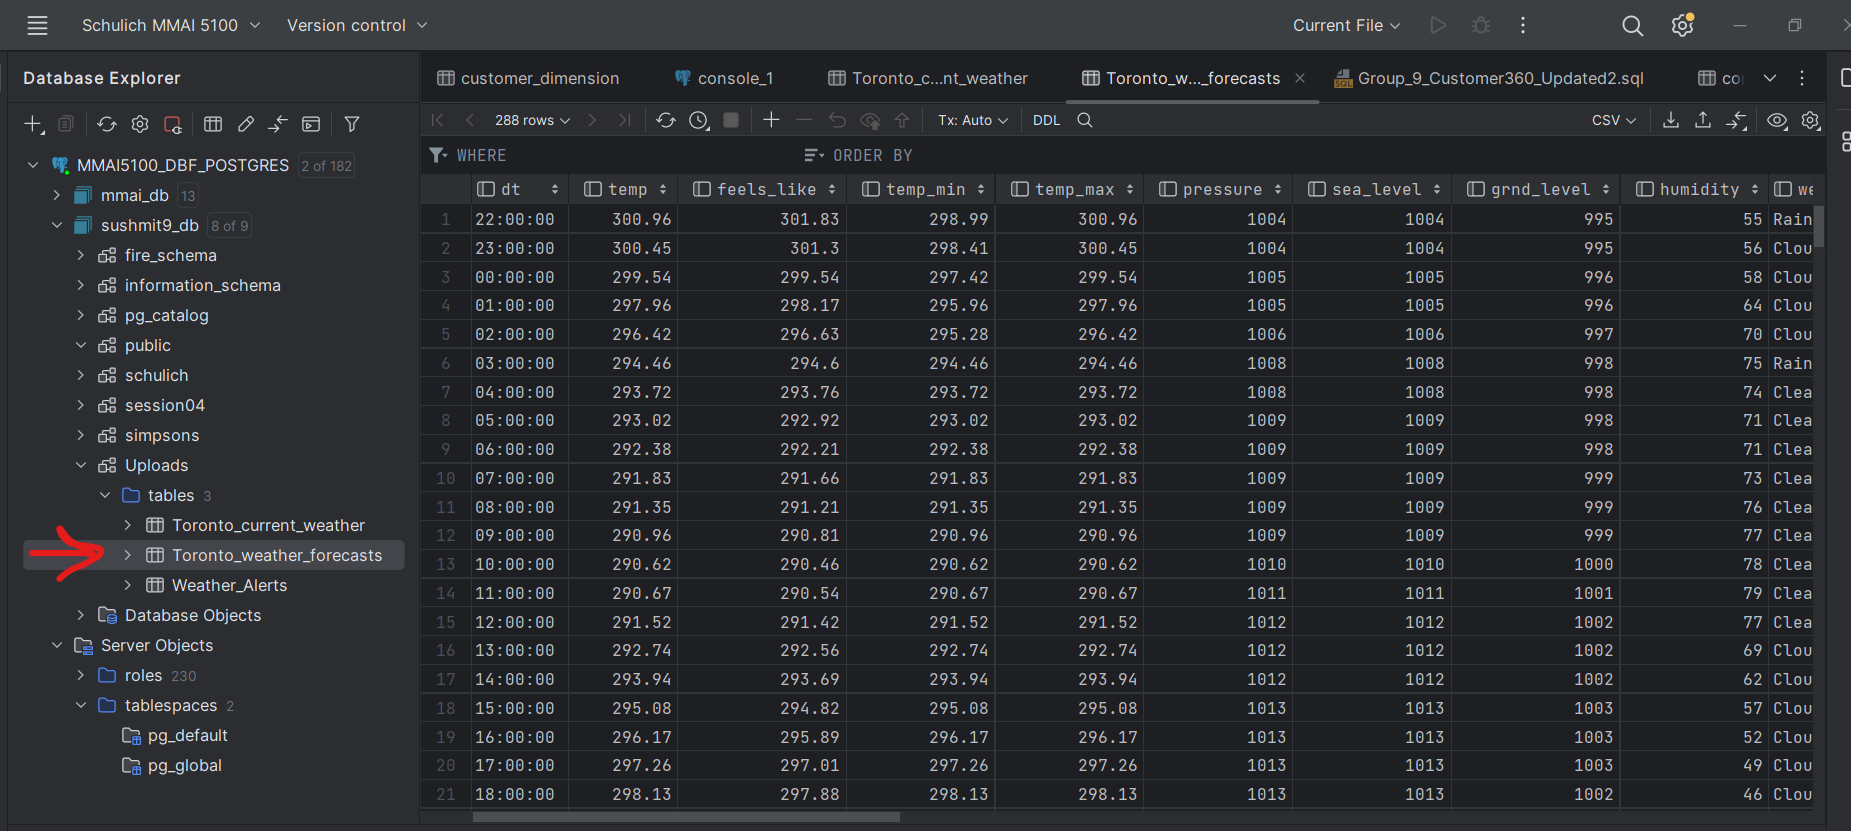

In [149]:
# Schedule the data fetching and ingestion process to run daily from the next day onwards
# P.S. - This is meant to be executed in the background. 
def schedule_daily_task2(hour, minute):
    while True:
        current_time = time.localtime()
        if current_time.tm_hour >= hour and current_time.tm_min >= minute:
            break
        time.sleep(60)  # Sleep for a minute

    while True:
        fetch_and_ingest_data2()
        print("Data fetching and ingestion process has been scheduled and executed.")
        time.sleep(24 * 60 * 60)  # Sleep for a day

# Schedule the data fetching and ingestion process to run every day at 12:00 PM
schedule_daily_task2(hour=12, minute=0)

Data fetching and ingestion process has been scheduled and executed.


# 3. Weather Alerts

#### Fetching the Data

In [18]:
# Data Source for alerts: https://dd.weather.gc.ca/alerts/cap/
# Data Source for Canadian cities-post codes: https://raw.githubusercontent.com/offcial17/schulich_data_science/main/ca_geo_dimension.csv
url3 = "https://dd.weather.gc.ca/alerts/cap/"
city = pd.read_csv('https://raw.githubusercontent.com/offcial17/schulich_data_science/main/ca_geo_dimension.csv')

In [19]:
# This function is used to scrape webpages containing links to CAP files, identify the latest CAP file link based on the date in the link,
# and return the URL of the latest CAP file.

def find_latest_cap_url(base_url):
    # Send an HTTP GET request to the URL
    response = requests.get(base_url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        
        # Find all anchor (a) elements that point to CAP files
        cap_folder_links = soup.find_all("a", href=True, string=True)
        
        latest_cap_folder_link = None
        latest_date = None
        
        # Iterate through CAP folder links to find the latest one
        for link in cap_folder_links:
            href = link.get("href")
            if href.endswith("/") and len(href) == 9 and href[:-1].isdigit():
                date = href[:-1]
                if latest_date is None or date > latest_date:
                    latest_date = date
                    latest_cap_folder_link = href
        
        if latest_cap_folder_link:
            latest_cap_file_link = f"{base_url}{latest_cap_folder_link}"
            return latest_cap_file_link
        else:
            return None
    else:
        return None

In [20]:
# This function finds and returns the URL of the most recently modified folder on a webpage. 

# It constructs a new URL with sorting parameters ('?C=M;O=A') to ensure that the webpage's content is sorted by modification date. 

# C=M: This part of the query string specifies the "C" parameter with the value "M," which stands for "Sort by Last Modified." 
# This indicates that the contents of the directory should be sorted based on the last modified timestamp of the files.

# O=A: This part of the query string specifies the "O" parameter with the value "A," which stands for "Order in Ascending." 
# This indicates that the sorting order should be ascending, meaning that files will be listed in order from the oldest to the newest.

# This way, it can reliably assume that the last link corresponds to the most recently modified folder.

def last_modified(url):
    # find the last modified folder
    sorted_new_url = url + '?C=M;O=A'
    
    response = requests.get(sorted_new_url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all the links on the webpage
    links = soup.find_all('a')

    # Last link is latest folder
    return url + links[-1].get('href')

In [21]:
#  To automate the process of identifying, downloading and saving the latest weather alert in CAP format(XML file) from the URL.
l_cap_url = find_latest_cap_url(url3)

new = last_modified(l_cap_url)
new = last_modified(new)
new_cap = last_modified(new)


#Download and write into new file
response = requests.get(new_cap)

# Save the file to disk
with open('latest_file.cap', 'wb') as file:
    file.write(response.content)

new_cap

'https://dd.weather.gc.ca/alerts/cap/20230813/LAND/21/T_QCCN00_C_LAND_202308132115_1634064975.cap'

In [23]:
# To parse the XML file, navigate to specific elements within the XML structure using namespaces and get the alert description text
# Path to the XML file
cap_file_path ='latest_file.cap'

# Parse the XML file
tree = ET.parse(cap_file_path)

# Get the root element
root = tree.getroot()

# Print the root element's tag
print("Root element:", root.tag)

# English version
info = root.find('{urn:oasis:names:tc:emergency:cap:1.2}info') 
description  = info.find('{urn:oasis:names:tc:emergency:cap:1.2}description').text
print(description)

Root element: {urn:oasis:names:tc:emergency:cap:1.2}alert

Les orages violents ont faibli ou ont quitté la région.


###



#### Feature Engineering

In [24]:
# To extracts and processes polygon coordinates from the XML file, converting them from a string format to a list of tuples 
# containing latitude and longitude values.

polygon_coords = info.find('{urn:oasis:names:tc:emergency:cap:1.2}area').find('{urn:oasis:names:tc:emergency:cap:1.2}polygon').text

# Convert the string to coordinates seperated by , and space
pairs = polygon_coords.split()
polygon_coords = [(float(x.split(',')[0]), float(x.split(',')[1])) for x in pairs]
print(polygon_coords)

[(48.3338, -71.5524), (48.262, -71.2779), (48.242, -71.1506), (48.2202, -71.1198), (48.1967, -71.0311), (48.1917, -71.0126), (48.1886, -71.0163), (48.18, -71.0163), (47.7998, -71.0164), (47.791, -71.5114), (47.7998, -72.0027), (48.2497, -72.0026), (48.2499, -72.0026), (48.3338, -71.5524)]


In [25]:
# To filter cities from the provided City-Post Codes Dataset that are located within the polygon coordinates
# Create a polygon using the coordinates
polygon = Polygon(polygon_coords)

# Filter cities within the polygon
filtered_cities = []
for  _,row in city.iterrows():
    point = Point(row["latitude"], row["longitude"])
    if polygon.contains(point):
        filtered_cities.append(row["region"]) #the city name colunms

# Remove duplicate city names by converting the list to a set and back to a list
filtered_cities = list(set(filtered_cities))
print("Cities within the polygon:", filtered_cities)

Cities within the polygon: ['Saguenay-Lac-Saint-Jean']


In [26]:
# To extract specific attributes from the XML data and store them in a DataFrame,
info_dict = {
    "language": info.find('{urn:oasis:names:tc:emergency:cap:1.2}language').text,
    "event": info.find('{urn:oasis:names:tc:emergency:cap:1.2}event').text,
    "responseType": info.find('{urn:oasis:names:tc:emergency:cap:1.2}responseType').text,
    "urgency": info.find('{urn:oasis:names:tc:emergency:cap:1.2}urgency').text,
    "severity": info.find('{urn:oasis:names:tc:emergency:cap:1.2}severity').text,
    "certainty": info.find('{urn:oasis:names:tc:emergency:cap:1.2}certainty').text,
    "audience": info.find('{urn:oasis:names:tc:emergency:cap:1.2}audience').text,
    "effective": info.find('{urn:oasis:names:tc:emergency:cap:1.2}effective').text,
    "expires": info.find('{urn:oasis:names:tc:emergency:cap:1.2}expires').text,
    "senderName": info.find('{urn:oasis:names:tc:emergency:cap:1.2}senderName').text,
    "headline": info.find('{urn:oasis:names:tc:emergency:cap:1.2}headline').text,
    "description": info.find('{urn:oasis:names:tc:emergency:cap:1.2}description').text.strip(),
    "cities": ", ".join(filtered_cities) # to include cities within the polygon
}

# Convert the dictionary to a dataframe
df3 = pd.DataFrame([info_dict])

df3.head()

,language,event,responseType,urgency,severity,certainty,audience,effective,expires,senderName,headline,description,cities
0,fr-CA,orages,AllClear,Past,Minor,Observed,grand public,2023-08-13T21:15:02-00:00,2023-08-13T22:15:02-00:00,Environnement Canada,alerte d'orages violents annulée,Les orages violents ont faibli ou ont quitté l...,Saguenay-Lac-Saint-Jean


#### Data Ingestion Pipeline

In [31]:
# Function to fetch and ingest data - compiling everything above into a function
def fetch_and_ingest_data3():
    l_cap_url = find_latest_cap_url(url3)
    
    new = last_modified(l_cap_url)
    new = last_modified(new)
    new_cap = last_modified(new)

    #Download and write into new file
    response = requests.get(new_cap)
    
    # Save the file to disk
    with open('latest_file.cap', 'wb') as file:
        file.write(response.content)

    # Path to the XML file
    cap_file_path ='latest_file.cap'
    
    # Parse the XML file
    tree = ET.parse(cap_file_path)
    
    # Get the root element
    root = tree.getroot()
    
    # Get Alert Description
    info = root.find('{urn:oasis:names:tc:emergency:cap:1.2}info') 
    description  = info.find('{urn:oasis:names:tc:emergency:cap:1.2}description').text 
    
    polygon_coords = info.find('{urn:oasis:names:tc:emergency:cap:1.2}area').find('{urn:oasis:names:tc:emergency:cap:1.2}polygon').text
    
    # Convert the string to coordinates seperated by , and space
    pairs = polygon_coords.split()
    polygon_coords = [(float(x.split(',')[0]), float(x.split(',')[1])) for x in pairs]

    # Create a polygon using the coordinates
    polygon = Polygon(polygon_coords)
    
    # Filter cities within the polygon
    filtered_cities = []
    for  _,row in city.iterrows():
        point = Point(row["latitude"], row["longitude"])
    if polygon.contains(point):
        filtered_cities.append(row["region"]) #the city name colunms
    
    #Remove duplicate city names by converting the list to a set and back to a list
    filtered_cities = list(set(filtered_cities))

    # To extract specific attributes from the XML data and store them in a DataFrame,
    info_dict = {
    "language": info.find('{urn:oasis:names:tc:emergency:cap:1.2}language').text,
    "event": info.find('{urn:oasis:names:tc:emergency:cap:1.2}event').text,
    "responseType": info.find('{urn:oasis:names:tc:emergency:cap:1.2}responseType').text,
    "urgency": info.find('{urn:oasis:names:tc:emergency:cap:1.2}urgency').text,
    "severity": info.find('{urn:oasis:names:tc:emergency:cap:1.2}severity').text,
    "certainty": info.find('{urn:oasis:names:tc:emergency:cap:1.2}certainty').text,
    "audience": info.find('{urn:oasis:names:tc:emergency:cap:1.2}audience').text,
    "effective": info.find('{urn:oasis:names:tc:emergency:cap:1.2}effective').text,
    "expires": info.find('{urn:oasis:names:tc:emergency:cap:1.2}expires').text,
    "senderName": info.find('{urn:oasis:names:tc:emergency:cap:1.2}senderName').text,
    "headline": info.find('{urn:oasis:names:tc:emergency:cap:1.2}headline').text,
    "description": info.find('{urn:oasis:names:tc:emergency:cap:1.2}description').text.strip(),
    "cities": ", ".join(filtered_cities) # to include cities within the polygon
    }
    
    # Convert the dictionary to a dataframe
    df3 = pd.DataFrame([info_dict])

    #Pushing dataframe to Database Schema
    df3.to_sql(
    name      = 'Weather_Alerts',
    con       = my_db_engine,
    schema    = 'Uploads',
    if_exists = 'append', # add new rows to the existing table
    index     = False,
    method    = 'multi',
    dtype     = {
        'language'    : sa.types.VARCHAR(10),
        'event'       : sa.types.VARCHAR(50),
        'responseType': sa.types.VARCHAR(30),
        'urgency'     : sa.types.VARCHAR(30),
        'severity'    : sa.types.VARCHAR(30),
        'certainty'   : sa.types.VARCHAR(30),
        'audience'    : sa.types.VARCHAR(50),
        'effective'   : sa.types.VARCHAR(50),
        'expires'     : sa.types.VARCHAR(50),
        'senderName'  : sa.types.VARCHAR(50),
        'headline'    : sa.types.VARCHAR(100),
        'description' : sa.types.VARCHAR(),
        'cities'      : sa.types.TEXT 
        }
    )

# Immediately run the data fetching and ingestion process
print("Running data fetching and ingestion process immediately...")
fetch_and_ingest_data3()
print("Data fetching and ingestion process has been executed.")

Running data fetching and ingestion process immediately...
Data fetching and ingestion process has been executed.


0    Saguenay-Lac-Saint-Jean
Name: cities, dtype: object

Evidence
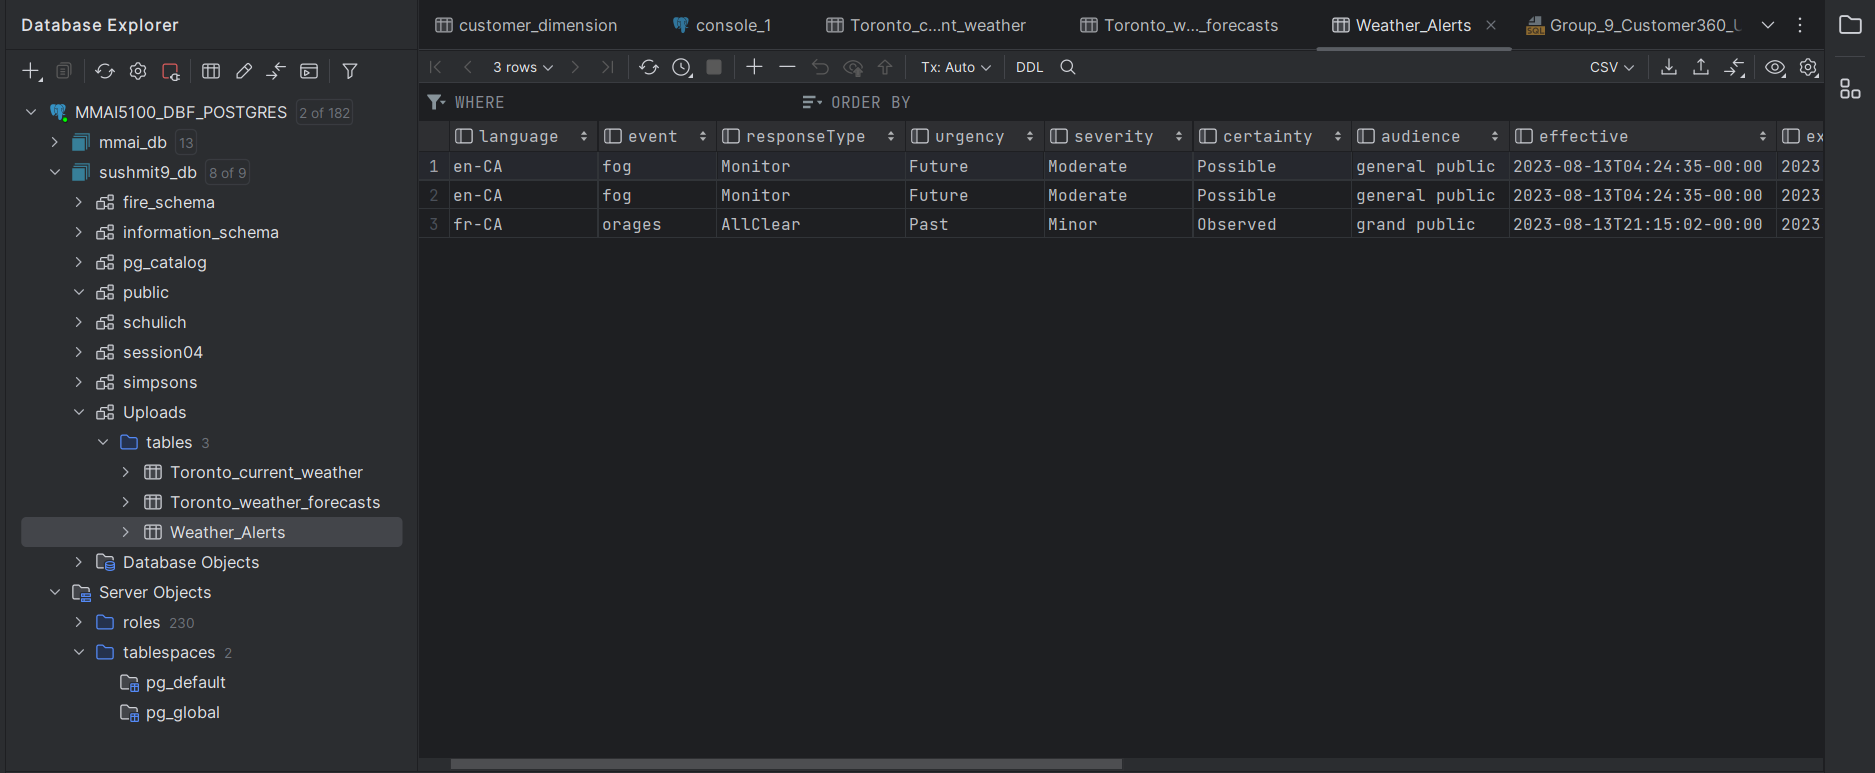

In [16]:
# Schedule the data fetching and ingestion process to run daily from the next day onwards
# P.S. - This is meant to be executed in the background. 
def schedule_daily_task3(hour, minute):
    while True:
        current_time = time.localtime()
        if current_time.tm_hour >= hour and current_time.tm_min >= minute:
            break
        time.sleep(60)  # Sleep for a minute

    while True:
        fetch_and_ingest_data3()
        print("Data fetching and ingestion process has been scheduled and executed.")
        time.sleep(24 * 60 * 60)  # Sleep for a day

# Schedule the data fetching and ingestion process to run every day at 12:00 PM
schedule_daily_task3(hour=12, minute=0)